# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.0.0


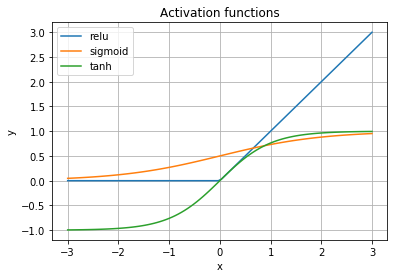

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.0.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [4]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
#     pass

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    import os
    cifar10_dir = "data/cifar-10-batches-py"
    all_batches = []
    all_labels = []
    for b in range(1,6):
        f_train_curr = os.path.join(cifar10_dir, 'data_batch_%d' %b)
        d_data, d_labels = unpickle(f_train_curr)
        batch = d_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
#         print(batch.shape)
        labels = np.array(d_labels)
        all_batches.append(batch)
        all_labels.append(labels)
        
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
#     print(data_train.shape, labels_train.shape)
    x_train = data_train[:num_training]
    x_val = data_train[num_training:]
    y_train = labels_train[:num_training]
    y_val = labels_train[num_training:]
    del batch, labels
    return x_train, y_train, x_val, y_val
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
#     pass

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    import os
    cifar10_dir = "data/cifar-10-batches-py"
    f_test = os.path.join(cifar10_dir, 'test_batch')
    d_data, d_labels = unpickle(f_test)
    data_test = d_data.reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
    labels_test = np.array(d_labels)
    return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [5]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


    
#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def avg_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.avg_pool(input, ksize=ksize, strides=strides, padding='SAME')
    
def drop(input, keep_prob, training):
    return tf.layers.dropout(input, 1-keep_prob, training=training)
    
def fc(input,units):
    return tf.contrib.layers.fully_connected(input, units,activation_fn=None)
    
def bn(input, training, reuse=None):
    return tf.layers.batch_normalization(inputs=input, training=training, reuse=reuse)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [6]:
# tf.reset_default_graph()
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
# X = tf.convert_to_tensor(X_val,dtype=tf.float32)
# conv1 = conv2d(X, 7, 1, 32)
# relu1 = tf.nn.relu(conv1)
# pool1 = max_pool(relu1, 3, 2)            
# print('conv1 layer: ' + str(pool1.get_shape()))

In [10]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 8*8*64])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            self.dropout = tf.layers.dropout(self.relu3, 1-self.keep_prob, training=self.is_train)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.dropout.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.dropout, 10)          
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
#         global_step = tf.Variable(0, trainable=False)
        global_step = tf.contrib.framework.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(5e-4,global_step,500,0.96,staircase=True)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.loss_op, global_step=global_step) 
#         print(global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob:0.5, self.is_train:True}              
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(1,2,1)
            plt.plot(losses,'r')
            plt.title("Losses")
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(1,2,2)
            plt.plot(accuracies,'g')
            plt.title("Accuracies")
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y : Y_, self.keep_prob:0.5, self.is_train: False}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 28.994, accuracy = 0.125
iteration (50): loss = 2.045, accuracy = 0.234
iteration (100): loss = 1.783, accuracy = 0.328
iteration (150): loss = 1.774, accuracy = 0.383
iteration (200): loss = 1.693, accuracy = 0.398
iteration (250): loss = 1.598, accuracy = 0.445
iteration (300): loss = 1.502, accuracy = 0.500
iteration (350): loss = 1.506, accuracy = 0.430


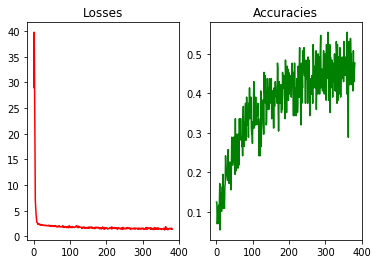

validation for epoch 0
-  epoch 0: validation accuracy = 0.523
train for epoch 1
iteration (400): loss = 1.402, accuracy = 0.547
iteration (450): loss = 1.486, accuracy = 0.516
iteration (500): loss = 1.517, accuracy = 0.414
iteration (550): loss = 1.282, accuracy = 0.641
iteration (600): loss = 1.222, accuracy = 0.539
iteration (650): loss = 1.499, accuracy = 0.453
iteration (700): loss = 1.373, accuracy = 0.516
iteration (750): loss = 1.114, accuracy = 0.586


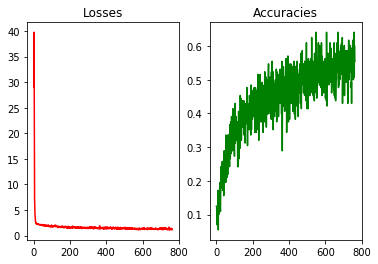

validation for epoch 1
-  epoch 1: validation accuracy = 0.557
train for epoch 2
iteration (800): loss = 1.217, accuracy = 0.539
iteration (850): loss = 1.338, accuracy = 0.516
iteration (900): loss = 1.223, accuracy = 0.609
iteration (950): loss = 1.106, accuracy = 0.578
iteration (1000): loss = 1.195, accuracy = 0.547
iteration (1050): loss = 1.134, accuracy = 0.625
iteration (1100): loss = 1.030, accuracy = 0.656


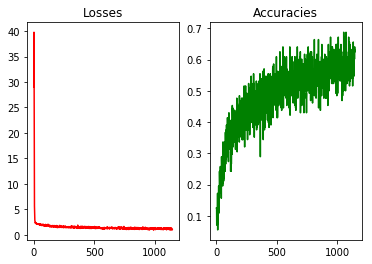

validation for epoch 2
-  epoch 2: validation accuracy = 0.589
train for epoch 3
iteration (1150): loss = 1.049, accuracy = 0.617
iteration (1200): loss = 1.042, accuracy = 0.609
iteration (1250): loss = 1.159, accuracy = 0.570
iteration (1300): loss = 1.113, accuracy = 0.594
iteration (1350): loss = 0.937, accuracy = 0.719
iteration (1400): loss = 1.317, accuracy = 0.625
iteration (1450): loss = 1.105, accuracy = 0.594
iteration (1500): loss = 0.938, accuracy = 0.664


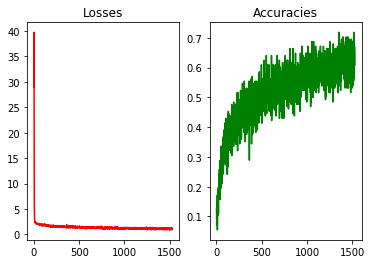

validation for epoch 3
-  epoch 3: validation accuracy = 0.581
train for epoch 4
iteration (1550): loss = 0.859, accuracy = 0.758
iteration (1600): loss = 0.963, accuracy = 0.672
iteration (1650): loss = 1.078, accuracy = 0.648
iteration (1700): loss = 1.079, accuracy = 0.594
iteration (1750): loss = 1.056, accuracy = 0.656
iteration (1800): loss = 0.918, accuracy = 0.648
iteration (1850): loss = 1.038, accuracy = 0.625
iteration (1900): loss = 1.013, accuracy = 0.609


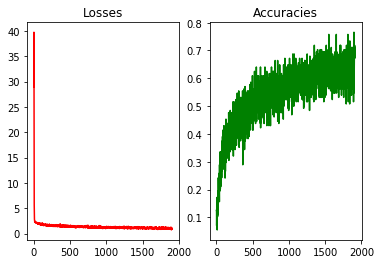

validation for epoch 4
-  epoch 4: validation accuracy = 0.625
***** test accuracy: 0.619
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [12]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/gpu:0'):  # I use GPU to train, after training I retrieve the code
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [13]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 50

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 3, 1, 96)
            self.bn1 = bn(self.conv1, self.is_train)
            self.relu1 = tf.nn.relu(self.bn1)
            self.pool1 = max_pool(self.relu1, 2, 2)
            print('conv1 layer: '+ str(self.pool1.get_shape()))
            
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 3, 1, 256)
            self.bn2 = bn(self.conv2, self.is_train)
            self.relu2 = tf.nn.relu(self.bn2)
            self.pool2 = max_pool(self.relu2, 2, 2)
            print('conv2 layer: '+ str(self.pool2.get_shape()))
            
            
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2, 3, 1, 384)
            self.relu3 = tf.nn.relu(self.conv3)
            self.drop3 = drop(self.relu3, self.keep_prob, self.is_train)
            print('conv3 layer: '+ str(self.relu3.get_shape()))
            
            
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.drop3, 3, 1, 384)
            self.relu4 = tf.nn.relu(self.conv4)
            self.pool4 = max_pool(self.relu4, 2, 2)
            print('conv4 layer: '+ str(self.pool4.get_shape()))
            
            
        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.pool4, 3, 1, 256)
            self.relu5 = tf.nn.relu(self.conv5)
            self.pool5 = avg_pool(self.relu5, 2, 2)
            print('conv5 layer: '+ str(self.pool5.get_shape()))
            
            
        self.flat = tf.reshape(self.pool5, [-1,2*2*256])
        
        
        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.flat, 128)
            self.drop6 = drop(self.fc6, self.keep_prob, self.is_train)
            print('fc6 layer: '+ str(self.drop6.get_shape()))
            
            
        with tf.variable_scope('fc7'):
            self.fc7 = fc(self.drop6, 10)
            print('fc7 layer: '+ str(self.fc7.get_shape()))
        return self.fc7


    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
#         self.reuse = tf.placeholder(tf.bool)
      
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        global_step = tf.contrib.framework.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(5e-4,global_step,500,0.96,staircase=True)
#         if self.use_batch_norm:
#             # If we don't include the update ops as dependencies on the train step, the 
#             # tf.layers.batch_normalization layers won't update their population statistics,
#             # which will cause the model to fail at inference time
#             with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#                 train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
#         else:
#             train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.train_op = tf.train.AdamOptimizer(
                learning_rate=learning_rate).minimize(self.loss_op, global_step=global_step) 
#         print(global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
        
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
#         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#         with tf.control_dependencies(update_ops):
#             train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                
                feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob:0.5, self.is_train:True}              
                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(1,2,1)
            plt.plot(losses,'r')
            plt.title("Losses")
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(1,2,2)
            plt.plot(accuracies,'g')
            plt.title("Accuracies")
            plt.show()
            

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            feed_dict = {self.X: X_, self.Y : Y_, self.keep_prob:0.5, self.is_train: False}
            
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

In [14]:
# # Clear old computation graphs
# tf.reset_default_graph()

# # Train our sample model
# with tf.Session() as sess:
#     model = YourModel()
#     model.train(sess, X_train, Y_train, X_val, Y_val)
#     accuracy = model.evaluate(sess, X_test, Y_test)
#     print('***** test accuracy: %.3f' % accuracy)
#     saver = tf.train.Saver()
#     model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
#     print("Model saved in %s" % model_path)

In [15]:
# from sklearn.preprocessing import StandardScaler

load finished
-----  Your model  -----
conv1 layer: (?, 16, 16, 96)
conv2 layer: (?, 8, 8, 256)
conv3 layer: (?, 8, 8, 384)
conv4 layer: (?, 4, 4, 384)
conv5 layer: (?, 2, 2, 256)
fc6 layer: (?, 128)
fc7 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.074, accuracy = 0.164
iteration (50): loss = 1.907, accuracy = 0.234
iteration (100): loss = 1.682, accuracy = 0.398
iteration (150): loss = 1.585, accuracy = 0.422
iteration (200): loss = 1.500, accuracy = 0.422
iteration (250): loss = 1.562, accuracy = 0.391
iteration (300): loss = 1.363, accuracy = 0.484
iteration (350): loss = 1.427, accuracy = 0.469


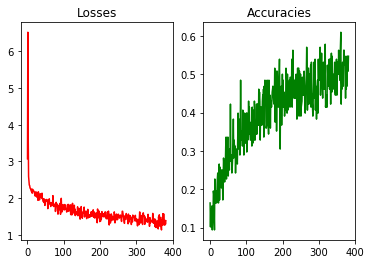

validation for epoch 0
-  epoch 0: validation accuracy = 0.445
train for epoch 1
iteration (400): loss = 1.299, accuracy = 0.547
iteration (450): loss = 1.321, accuracy = 0.523
iteration (500): loss = 1.282, accuracy = 0.500
iteration (550): loss = 0.982, accuracy = 0.648
iteration (600): loss = 1.012, accuracy = 0.664
iteration (650): loss = 1.273, accuracy = 0.516
iteration (700): loss = 1.279, accuracy = 0.578
iteration (750): loss = 0.952, accuracy = 0.680


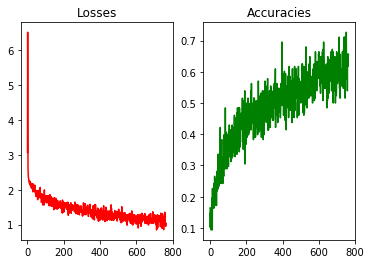

validation for epoch 1
-  epoch 1: validation accuracy = 0.471
train for epoch 2
iteration (800): loss = 1.043, accuracy = 0.617
iteration (850): loss = 1.119, accuracy = 0.578
iteration (900): loss = 0.971, accuracy = 0.664
iteration (950): loss = 0.891, accuracy = 0.719
iteration (1000): loss = 0.933, accuracy = 0.672
iteration (1050): loss = 0.849, accuracy = 0.711
iteration (1100): loss = 0.793, accuracy = 0.727


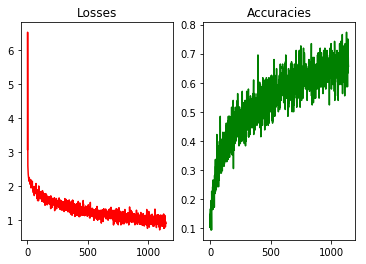

validation for epoch 2
-  epoch 2: validation accuracy = 0.550
train for epoch 3
iteration (1150): loss = 0.924, accuracy = 0.641
iteration (1200): loss = 0.716, accuracy = 0.766
iteration (1250): loss = 0.988, accuracy = 0.633
iteration (1300): loss = 0.942, accuracy = 0.641
iteration (1350): loss = 0.788, accuracy = 0.734
iteration (1400): loss = 0.896, accuracy = 0.727
iteration (1450): loss = 0.745, accuracy = 0.797
iteration (1500): loss = 0.787, accuracy = 0.719


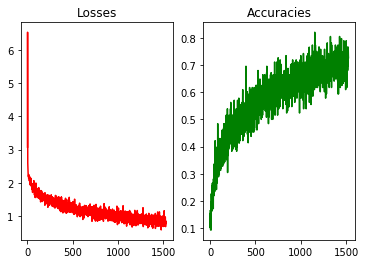

validation for epoch 3
-  epoch 3: validation accuracy = 0.702
train for epoch 4
iteration (1550): loss = 0.623, accuracy = 0.773
iteration (1600): loss = 0.750, accuracy = 0.773
iteration (1650): loss = 0.903, accuracy = 0.695
iteration (1700): loss = 0.838, accuracy = 0.633
iteration (1750): loss = 0.917, accuracy = 0.703
iteration (1800): loss = 0.751, accuracy = 0.742
iteration (1850): loss = 0.868, accuracy = 0.703
iteration (1900): loss = 0.875, accuracy = 0.680


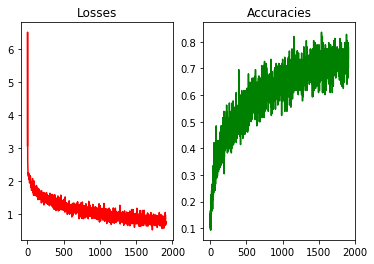

validation for epoch 4
-  epoch 4: validation accuracy = 0.517
train for epoch 5
iteration (1950): loss = 0.812, accuracy = 0.711
iteration (2000): loss = 0.628, accuracy = 0.789
iteration (2050): loss = 0.713, accuracy = 0.773
iteration (2100): loss = 0.854, accuracy = 0.742
iteration (2150): loss = 0.903, accuracy = 0.688
iteration (2200): loss = 0.712, accuracy = 0.781
iteration (2250): loss = 0.664, accuracy = 0.773


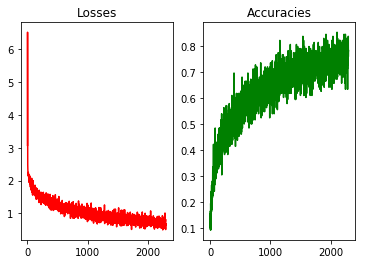

validation for epoch 5
-  epoch 5: validation accuracy = 0.535
train for epoch 6
iteration (2300): loss = 0.685, accuracy = 0.781
iteration (2350): loss = 0.617, accuracy = 0.789
iteration (2400): loss = 0.735, accuracy = 0.773
iteration (2450): loss = 0.703, accuracy = 0.734
iteration (2500): loss = 0.681, accuracy = 0.781
iteration (2550): loss = 0.728, accuracy = 0.703
iteration (2600): loss = 0.506, accuracy = 0.812
iteration (2650): loss = 0.767, accuracy = 0.758


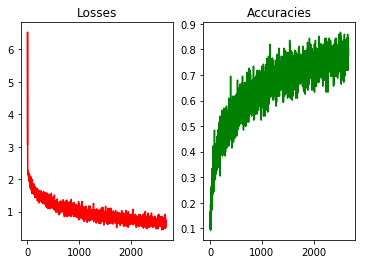

validation for epoch 6
-  epoch 6: validation accuracy = 0.580
train for epoch 7
iteration (2700): loss = 0.636, accuracy = 0.820
iteration (2750): loss = 0.759, accuracy = 0.742
iteration (2800): loss = 0.593, accuracy = 0.781
iteration (2850): loss = 0.636, accuracy = 0.828
iteration (2900): loss = 0.528, accuracy = 0.820
iteration (2950): loss = 0.758, accuracy = 0.727
iteration (3000): loss = 0.533, accuracy = 0.836
iteration (3050): loss = 0.662, accuracy = 0.766


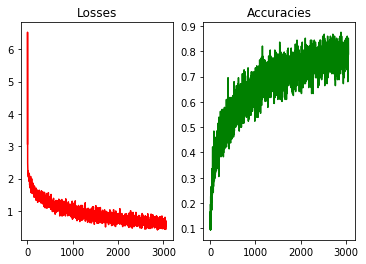

validation for epoch 7
-  epoch 7: validation accuracy = 0.632
train for epoch 8
iteration (3100): loss = 0.565, accuracy = 0.805
iteration (3150): loss = 0.709, accuracy = 0.789
iteration (3200): loss = 0.709, accuracy = 0.742
iteration (3250): loss = 0.680, accuracy = 0.781
iteration (3300): loss = 0.517, accuracy = 0.828
iteration (3350): loss = 0.652, accuracy = 0.742
iteration (3400): loss = 0.564, accuracy = 0.789


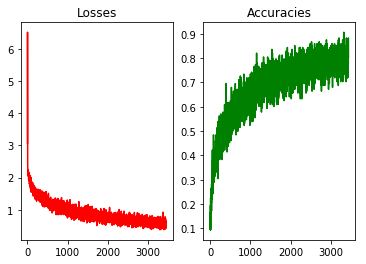

validation for epoch 8
-  epoch 8: validation accuracy = 0.685
train for epoch 9
iteration (3450): loss = 0.652, accuracy = 0.789
iteration (3500): loss = 0.559, accuracy = 0.789
iteration (3550): loss = 0.650, accuracy = 0.773
iteration (3600): loss = 0.521, accuracy = 0.828
iteration (3650): loss = 0.581, accuracy = 0.758
iteration (3700): loss = 0.709, accuracy = 0.742
iteration (3750): loss = 0.567, accuracy = 0.820
iteration (3800): loss = 0.562, accuracy = 0.828


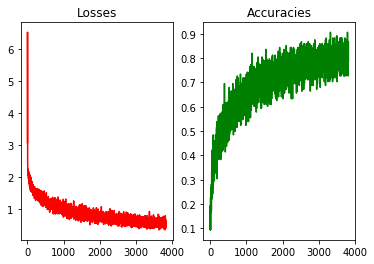

validation for epoch 9
-  epoch 9: validation accuracy = 0.699
train for epoch 10
iteration (3850): loss = 0.626, accuracy = 0.750
iteration (3900): loss = 0.511, accuracy = 0.805
iteration (3950): loss = 0.496, accuracy = 0.859
iteration (4000): loss = 0.509, accuracy = 0.836
iteration (4050): loss = 0.486, accuracy = 0.867
iteration (4100): loss = 0.540, accuracy = 0.820
iteration (4150): loss = 0.371, accuracy = 0.875
iteration (4200): loss = 0.458, accuracy = 0.875


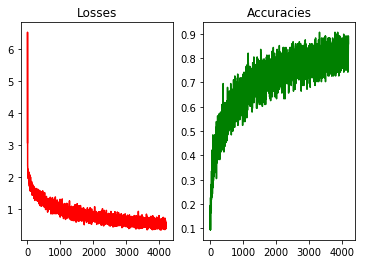

validation for epoch 10
-  epoch 10: validation accuracy = 0.785
train for epoch 11
iteration (4250): loss = 0.480, accuracy = 0.836
iteration (4300): loss = 0.474, accuracy = 0.836
iteration (4350): loss = 0.461, accuracy = 0.844
iteration (4400): loss = 0.453, accuracy = 0.852
iteration (4450): loss = 0.501, accuracy = 0.828
iteration (4500): loss = 0.530, accuracy = 0.836
iteration (4550): loss = 0.496, accuracy = 0.820


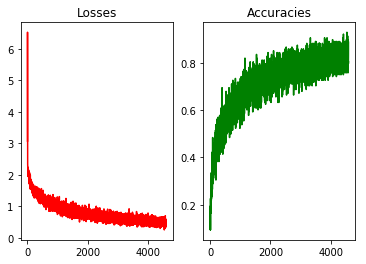

validation for epoch 11
-  epoch 11: validation accuracy = 0.672
train for epoch 12
iteration (4600): loss = 0.387, accuracy = 0.852
iteration (4650): loss = 0.714, accuracy = 0.773
iteration (4700): loss = 0.529, accuracy = 0.789
iteration (4750): loss = 0.504, accuracy = 0.836
iteration (4800): loss = 0.476, accuracy = 0.859
iteration (4850): loss = 0.410, accuracy = 0.883
iteration (4900): loss = 0.446, accuracy = 0.852
iteration (4950): loss = 0.453, accuracy = 0.844


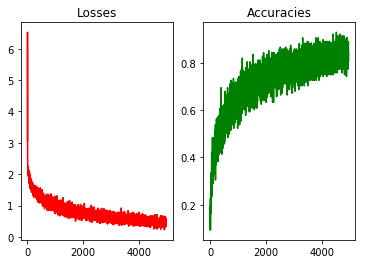

validation for epoch 12
-  epoch 12: validation accuracy = 0.733
train for epoch 13
iteration (5000): loss = 0.279, accuracy = 0.898
iteration (5050): loss = 0.441, accuracy = 0.836
iteration (5100): loss = 0.384, accuracy = 0.836
iteration (5150): loss = 0.542, accuracy = 0.789
iteration (5200): loss = 0.365, accuracy = 0.859
iteration (5250): loss = 0.365, accuracy = 0.906
iteration (5300): loss = 0.382, accuracy = 0.844


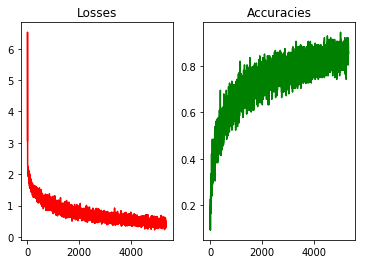

validation for epoch 13
-  epoch 13: validation accuracy = 0.761
train for epoch 14
iteration (5350): loss = 0.395, accuracy = 0.852
iteration (5400): loss = 0.423, accuracy = 0.859
iteration (5450): loss = 0.381, accuracy = 0.844
iteration (5500): loss = 0.457, accuracy = 0.859
iteration (5550): loss = 0.427, accuracy = 0.867
iteration (5600): loss = 0.293, accuracy = 0.891
iteration (5650): loss = 0.442, accuracy = 0.883
iteration (5700): loss = 0.402, accuracy = 0.844


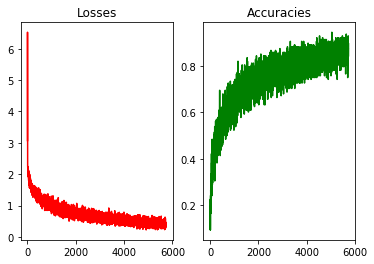

validation for epoch 14
-  epoch 14: validation accuracy = 0.785
train for epoch 15
iteration (5750): loss = 0.297, accuracy = 0.906
iteration (5800): loss = 0.539, accuracy = 0.812
iteration (5850): loss = 0.455, accuracy = 0.852
iteration (5900): loss = 0.319, accuracy = 0.914
iteration (5950): loss = 0.291, accuracy = 0.906
iteration (6000): loss = 0.336, accuracy = 0.859
iteration (6050): loss = 0.292, accuracy = 0.906
iteration (6100): loss = 0.378, accuracy = 0.852


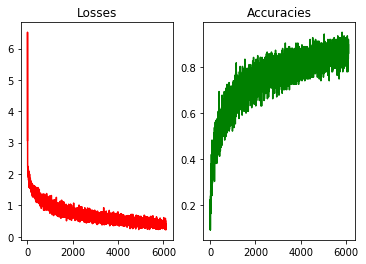

validation for epoch 15
-  epoch 15: validation accuracy = 0.804
train for epoch 16
iteration (6150): loss = 0.442, accuracy = 0.852
iteration (6200): loss = 0.427, accuracy = 0.836
iteration (6250): loss = 0.388, accuracy = 0.859
iteration (6300): loss = 0.319, accuracy = 0.906
iteration (6350): loss = 0.264, accuracy = 0.906
iteration (6400): loss = 0.446, accuracy = 0.852
iteration (6450): loss = 0.299, accuracy = 0.891


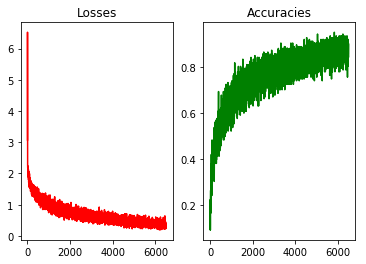

validation for epoch 16
-  epoch 16: validation accuracy = 0.789
train for epoch 17
iteration (6500): loss = 0.333, accuracy = 0.867
iteration (6550): loss = 0.337, accuracy = 0.883
iteration (6600): loss = 0.369, accuracy = 0.875
iteration (6650): loss = 0.401, accuracy = 0.867
iteration (6700): loss = 0.271, accuracy = 0.898
iteration (6750): loss = 0.464, accuracy = 0.820
iteration (6800): loss = 0.410, accuracy = 0.859
iteration (6850): loss = 0.257, accuracy = 0.906


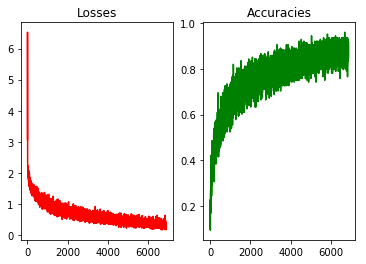

validation for epoch 17
-  epoch 17: validation accuracy = 0.801
train for epoch 18
iteration (6900): loss = 0.276, accuracy = 0.898
iteration (6950): loss = 0.437, accuracy = 0.875
iteration (7000): loss = 0.303, accuracy = 0.891
iteration (7050): loss = 0.251, accuracy = 0.922
iteration (7100): loss = 0.329, accuracy = 0.867
iteration (7150): loss = 0.386, accuracy = 0.875
iteration (7200): loss = 0.373, accuracy = 0.828
iteration (7250): loss = 0.336, accuracy = 0.883


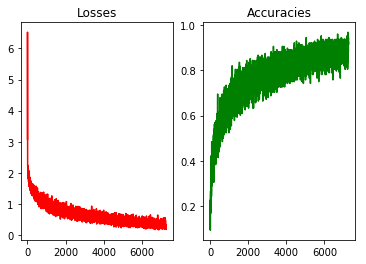

validation for epoch 18
-  epoch 18: validation accuracy = 0.777
train for epoch 19
iteration (7300): loss = 0.277, accuracy = 0.883
iteration (7350): loss = 0.304, accuracy = 0.875
iteration (7400): loss = 0.321, accuracy = 0.883
iteration (7450): loss = 0.211, accuracy = 0.938
iteration (7500): loss = 0.254, accuracy = 0.898
iteration (7550): loss = 0.335, accuracy = 0.867
iteration (7600): loss = 0.221, accuracy = 0.930


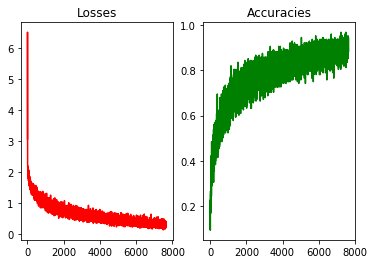

validation for epoch 19
-  epoch 19: validation accuracy = 0.819
train for epoch 20
iteration (7650): loss = 0.213, accuracy = 0.945
iteration (7700): loss = 0.194, accuracy = 0.922
iteration (7750): loss = 0.331, accuracy = 0.883
iteration (7800): loss = 0.318, accuracy = 0.914
iteration (7850): loss = 0.270, accuracy = 0.891
iteration (7900): loss = 0.346, accuracy = 0.875
iteration (7950): loss = 0.398, accuracy = 0.867
iteration (8000): loss = 0.321, accuracy = 0.867


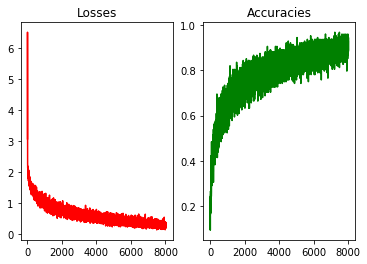

validation for epoch 20
-  epoch 20: validation accuracy = 0.754
train for epoch 21
iteration (8050): loss = 0.226, accuracy = 0.906
iteration (8100): loss = 0.284, accuracy = 0.914
iteration (8150): loss = 0.258, accuracy = 0.898
iteration (8200): loss = 0.288, accuracy = 0.883
iteration (8250): loss = 0.204, accuracy = 0.922
iteration (8300): loss = 0.137, accuracy = 0.953
iteration (8350): loss = 0.334, accuracy = 0.867
iteration (8400): loss = 0.199, accuracy = 0.922


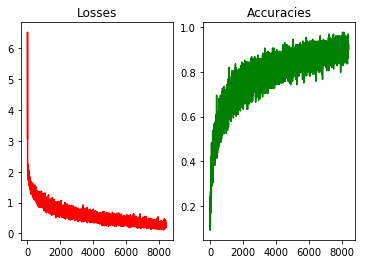

validation for epoch 21
-  epoch 21: validation accuracy = 0.788
train for epoch 22
iteration (8450): loss = 0.150, accuracy = 0.938
iteration (8500): loss = 0.272, accuracy = 0.914
iteration (8550): loss = 0.192, accuracy = 0.930
iteration (8600): loss = 0.202, accuracy = 0.938
iteration (8650): loss = 0.192, accuracy = 0.922
iteration (8700): loss = 0.362, accuracy = 0.875
iteration (8750): loss = 0.229, accuracy = 0.914


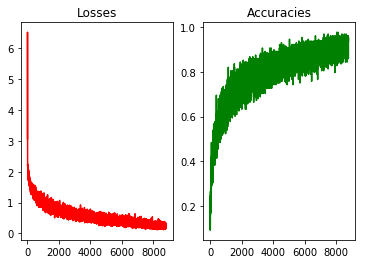

validation for epoch 22
-  epoch 22: validation accuracy = 0.828
train for epoch 23
iteration (8800): loss = 0.124, accuracy = 0.961
iteration (8850): loss = 0.326, accuracy = 0.883
iteration (8900): loss = 0.258, accuracy = 0.906
iteration (8950): loss = 0.174, accuracy = 0.953
iteration (9000): loss = 0.196, accuracy = 0.930
iteration (9050): loss = 0.231, accuracy = 0.930
iteration (9100): loss = 0.200, accuracy = 0.953
iteration (9150): loss = 0.309, accuracy = 0.922


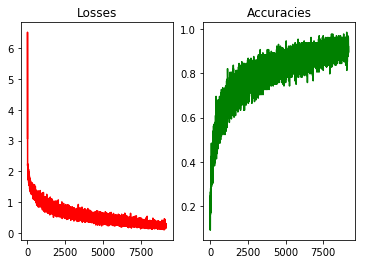

validation for epoch 23
-  epoch 23: validation accuracy = 0.826
train for epoch 24
iteration (9200): loss = 0.306, accuracy = 0.875
iteration (9250): loss = 0.254, accuracy = 0.891
iteration (9300): loss = 0.258, accuracy = 0.914
iteration (9350): loss = 0.189, accuracy = 0.930
iteration (9400): loss = 0.206, accuracy = 0.945
iteration (9450): loss = 0.209, accuracy = 0.930
iteration (9500): loss = 0.240, accuracy = 0.906


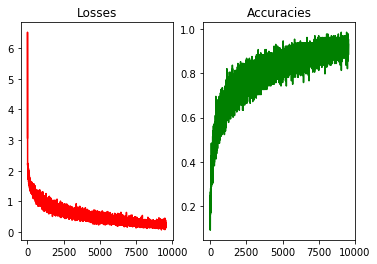

validation for epoch 24
-  epoch 24: validation accuracy = 0.807
train for epoch 25
iteration (9550): loss = 0.155, accuracy = 0.922
iteration (9600): loss = 0.291, accuracy = 0.906
iteration (9650): loss = 0.221, accuracy = 0.922
iteration (9700): loss = 0.294, accuracy = 0.914
iteration (9750): loss = 0.238, accuracy = 0.898
iteration (9800): loss = 0.160, accuracy = 0.938
iteration (9850): loss = 0.227, accuracy = 0.922
iteration (9900): loss = 0.226, accuracy = 0.898


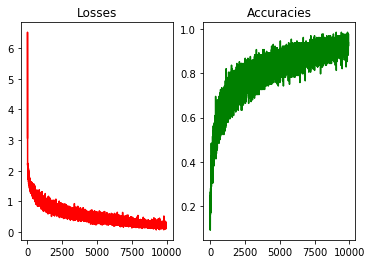

validation for epoch 25
-  epoch 25: validation accuracy = 0.826
train for epoch 26
iteration (9950): loss = 0.070, accuracy = 0.992
iteration (10000): loss = 0.176, accuracy = 0.938
iteration (10050): loss = 0.157, accuracy = 0.938
iteration (10100): loss = 0.241, accuracy = 0.891
iteration (10150): loss = 0.150, accuracy = 0.938
iteration (10200): loss = 0.150, accuracy = 0.953
iteration (10250): loss = 0.181, accuracy = 0.953
iteration (10300): loss = 0.232, accuracy = 0.906


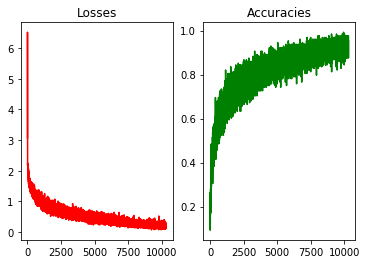

validation for epoch 26
-  epoch 26: validation accuracy = 0.792
train for epoch 27
iteration (10350): loss = 0.221, accuracy = 0.922
iteration (10400): loss = 0.175, accuracy = 0.938
iteration (10450): loss = 0.244, accuracy = 0.930
iteration (10500): loss = 0.143, accuracy = 0.961
iteration (10550): loss = 0.106, accuracy = 0.961
iteration (10600): loss = 0.104, accuracy = 0.977
iteration (10650): loss = 0.170, accuracy = 0.922


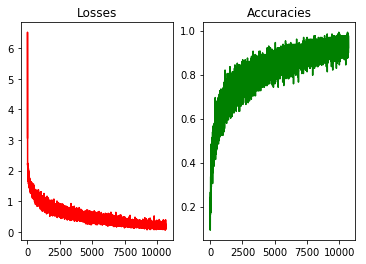

validation for epoch 27
-  epoch 27: validation accuracy = 0.821
train for epoch 28
iteration (10700): loss = 0.185, accuracy = 0.922
iteration (10750): loss = 0.087, accuracy = 0.961
iteration (10800): loss = 0.218, accuracy = 0.922
iteration (10850): loss = 0.186, accuracy = 0.938
iteration (10900): loss = 0.192, accuracy = 0.938
iteration (10950): loss = 0.155, accuracy = 0.930
iteration (11000): loss = 0.209, accuracy = 0.891
iteration (11050): loss = 0.088, accuracy = 0.961


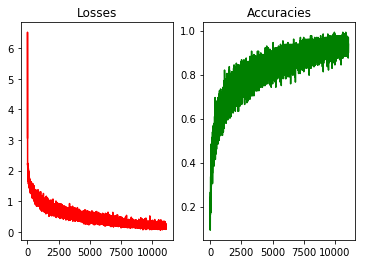

validation for epoch 28
-  epoch 28: validation accuracy = 0.814
train for epoch 29
iteration (11100): loss = 0.087, accuracy = 0.977
iteration (11150): loss = 0.155, accuracy = 0.945
iteration (11200): loss = 0.153, accuracy = 0.938
iteration (11250): loss = 0.256, accuracy = 0.914
iteration (11300): loss = 0.187, accuracy = 0.930
iteration (11350): loss = 0.173, accuracy = 0.953
iteration (11400): loss = 0.112, accuracy = 0.953
iteration (11450): loss = 0.154, accuracy = 0.938


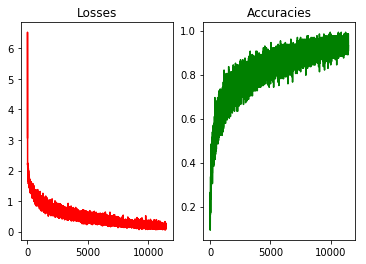

validation for epoch 29
-  epoch 29: validation accuracy = 0.802
train for epoch 30
iteration (11500): loss = 0.165, accuracy = 0.938
iteration (11550): loss = 0.064, accuracy = 0.984
iteration (11600): loss = 0.101, accuracy = 0.969
iteration (11650): loss = 0.232, accuracy = 0.938
iteration (11700): loss = 0.277, accuracy = 0.891
iteration (11750): loss = 0.131, accuracy = 0.969
iteration (11800): loss = 0.102, accuracy = 0.977


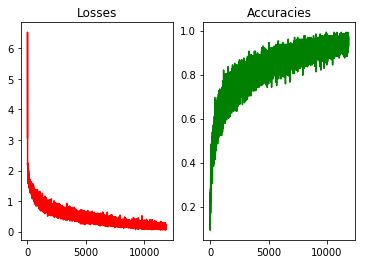

validation for epoch 30
-  epoch 30: validation accuracy = 0.802
train for epoch 31
iteration (11850): loss = 0.145, accuracy = 0.953
iteration (11900): loss = 0.216, accuracy = 0.930
iteration (11950): loss = 0.194, accuracy = 0.922
iteration (12000): loss = 0.259, accuracy = 0.906
iteration (12050): loss = 0.135, accuracy = 0.938
iteration (12100): loss = 0.216, accuracy = 0.945
iteration (12150): loss = 0.073, accuracy = 0.977
iteration (12200): loss = 0.112, accuracy = 0.969


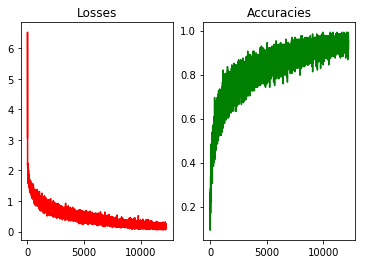

validation for epoch 31
-  epoch 31: validation accuracy = 0.788
train for epoch 32
iteration (12250): loss = 0.163, accuracy = 0.938
iteration (12300): loss = 0.123, accuracy = 0.961
iteration (12350): loss = 0.117, accuracy = 0.969
iteration (12400): loss = 0.159, accuracy = 0.914
iteration (12450): loss = 0.142, accuracy = 0.961
iteration (12500): loss = 0.105, accuracy = 0.961
iteration (12550): loss = 0.140, accuracy = 0.945
iteration (12600): loss = 0.157, accuracy = 0.953


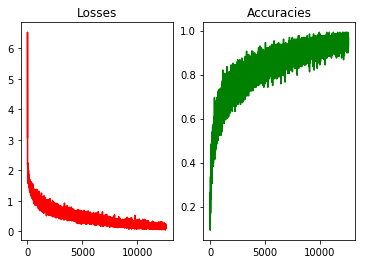

validation for epoch 32
-  epoch 32: validation accuracy = 0.789
train for epoch 33
iteration (12650): loss = 0.178, accuracy = 0.922
iteration (12700): loss = 0.095, accuracy = 0.984
iteration (12750): loss = 0.221, accuracy = 0.922
iteration (12800): loss = 0.128, accuracy = 0.945
iteration (12850): loss = 0.095, accuracy = 0.969
iteration (12900): loss = 0.122, accuracy = 0.961
iteration (12950): loss = 0.140, accuracy = 0.945


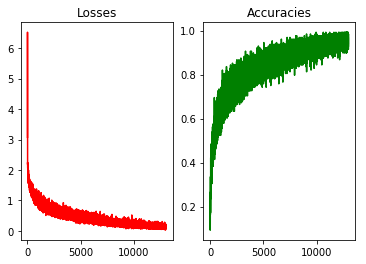

validation for epoch 33
-  epoch 33: validation accuracy = 0.817
train for epoch 34
iteration (13000): loss = 0.118, accuracy = 0.953
iteration (13050): loss = 0.144, accuracy = 0.953
iteration (13100): loss = 0.118, accuracy = 0.953
iteration (13150): loss = 0.117, accuracy = 0.953
iteration (13200): loss = 0.159, accuracy = 0.922
iteration (13250): loss = 0.133, accuracy = 0.953
iteration (13300): loss = 0.122, accuracy = 0.961
iteration (13350): loss = 0.146, accuracy = 0.945


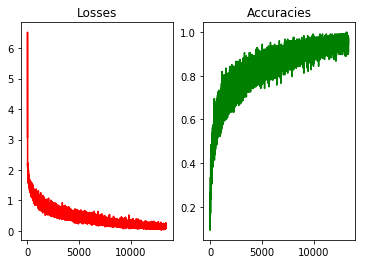

validation for epoch 34
-  epoch 34: validation accuracy = 0.816
train for epoch 35
iteration (13400): loss = 0.084, accuracy = 0.961
iteration (13450): loss = 0.114, accuracy = 0.977
iteration (13500): loss = 0.182, accuracy = 0.922
iteration (13550): loss = 0.087, accuracy = 0.961
iteration (13600): loss = 0.099, accuracy = 0.945
iteration (13650): loss = 0.191, accuracy = 0.914
iteration (13700): loss = 0.048, accuracy = 0.992
iteration (13750): loss = 0.067, accuracy = 0.977


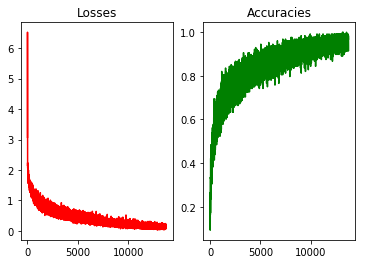

validation for epoch 35
-  epoch 35: validation accuracy = 0.820
train for epoch 36
iteration (13800): loss = 0.106, accuracy = 0.961
iteration (13850): loss = 0.109, accuracy = 0.961
iteration (13900): loss = 0.146, accuracy = 0.961
iteration (13950): loss = 0.130, accuracy = 0.945
iteration (14000): loss = 0.107, accuracy = 0.961
iteration (14050): loss = 0.133, accuracy = 0.961
iteration (14100): loss = 0.072, accuracy = 0.984


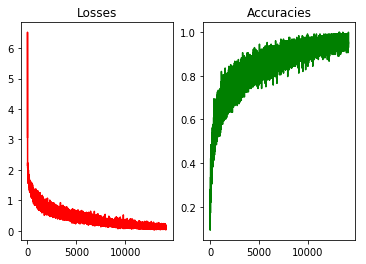

validation for epoch 36
-  epoch 36: validation accuracy = 0.824
train for epoch 37
iteration (14150): loss = 0.138, accuracy = 0.953
iteration (14200): loss = 0.220, accuracy = 0.945
iteration (14250): loss = 0.114, accuracy = 0.977
iteration (14300): loss = 0.077, accuracy = 0.969
iteration (14350): loss = 0.153, accuracy = 0.953
iteration (14400): loss = 0.099, accuracy = 0.969
iteration (14450): loss = 0.099, accuracy = 0.961
iteration (14500): loss = 0.102, accuracy = 0.977


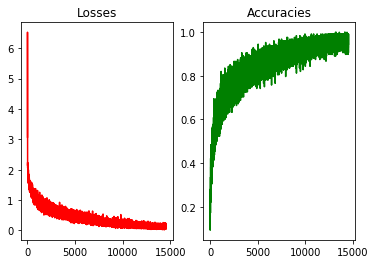

validation for epoch 37
-  epoch 37: validation accuracy = 0.825
train for epoch 38
iteration (14550): loss = 0.116, accuracy = 0.945
iteration (14600): loss = 0.096, accuracy = 0.969
iteration (14650): loss = 0.121, accuracy = 0.945
iteration (14700): loss = 0.101, accuracy = 0.961
iteration (14750): loss = 0.084, accuracy = 0.977
iteration (14800): loss = 0.117, accuracy = 0.953
iteration (14850): loss = 0.066, accuracy = 0.977


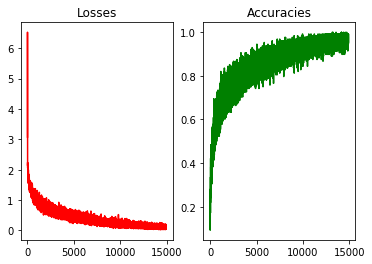

validation for epoch 38
-  epoch 38: validation accuracy = 0.791
train for epoch 39
iteration (14900): loss = 0.139, accuracy = 0.945
iteration (14950): loss = 0.144, accuracy = 0.953
iteration (15000): loss = 0.058, accuracy = 0.977
iteration (15050): loss = 0.044, accuracy = 0.984
iteration (15100): loss = 0.086, accuracy = 0.977
iteration (15150): loss = 0.117, accuracy = 0.969
iteration (15200): loss = 0.070, accuracy = 0.977
iteration (15250): loss = 0.158, accuracy = 0.961


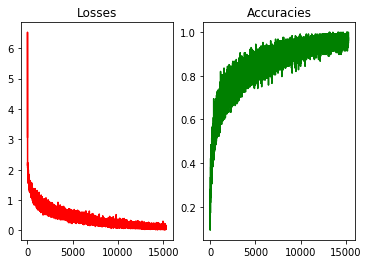

validation for epoch 39
-  epoch 39: validation accuracy = 0.838
train for epoch 40
iteration (15300): loss = 0.030, accuracy = 0.984
iteration (15350): loss = 0.179, accuracy = 0.938
iteration (15400): loss = 0.071, accuracy = 0.984
iteration (15450): loss = 0.064, accuracy = 0.969
iteration (15500): loss = 0.094, accuracy = 0.984
iteration (15550): loss = 0.106, accuracy = 0.953
iteration (15600): loss = 0.043, accuracy = 0.969
iteration (15650): loss = 0.102, accuracy = 0.945


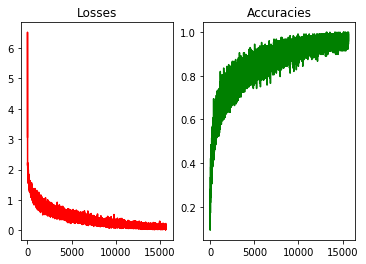

validation for epoch 40
-  epoch 40: validation accuracy = 0.812
train for epoch 41
iteration (15700): loss = 0.050, accuracy = 0.992
iteration (15750): loss = 0.085, accuracy = 0.961
iteration (15800): loss = 0.100, accuracy = 0.961
iteration (15850): loss = 0.054, accuracy = 0.984
iteration (15900): loss = 0.054, accuracy = 0.984
iteration (15950): loss = 0.189, accuracy = 0.953
iteration (16000): loss = 0.093, accuracy = 0.961


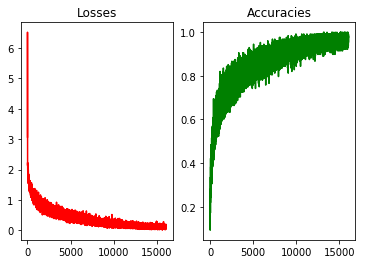

validation for epoch 41
-  epoch 41: validation accuracy = 0.808
train for epoch 42
iteration (16050): loss = 0.077, accuracy = 0.961
iteration (16100): loss = 0.135, accuracy = 0.945
iteration (16150): loss = 0.130, accuracy = 0.930
iteration (16200): loss = 0.080, accuracy = 0.969
iteration (16250): loss = 0.080, accuracy = 0.984
iteration (16300): loss = 0.092, accuracy = 0.969
iteration (16350): loss = 0.150, accuracy = 0.945
iteration (16400): loss = 0.107, accuracy = 0.953


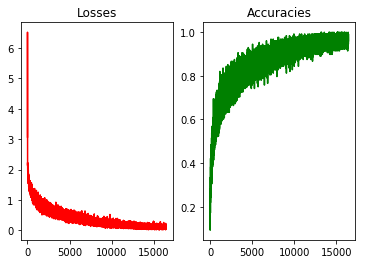

validation for epoch 42
-  epoch 42: validation accuracy = 0.809
train for epoch 43
iteration (16450): loss = 0.064, accuracy = 0.977
iteration (16500): loss = 0.024, accuracy = 0.992
iteration (16550): loss = 0.047, accuracy = 0.992
iteration (16600): loss = 0.053, accuracy = 0.977
iteration (16650): loss = 0.137, accuracy = 0.953
iteration (16700): loss = 0.074, accuracy = 0.977
iteration (16750): loss = 0.052, accuracy = 0.977
iteration (16800): loss = 0.060, accuracy = 0.984


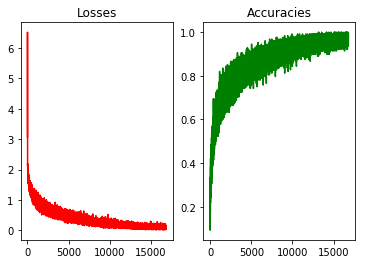

validation for epoch 43
-  epoch 43: validation accuracy = 0.818
train for epoch 44
iteration (16850): loss = 0.104, accuracy = 0.977
iteration (16900): loss = 0.100, accuracy = 0.961
iteration (16950): loss = 0.149, accuracy = 0.969
iteration (17000): loss = 0.060, accuracy = 0.977
iteration (17050): loss = 0.043, accuracy = 0.992
iteration (17100): loss = 0.069, accuracy = 0.977
iteration (17150): loss = 0.070, accuracy = 0.977


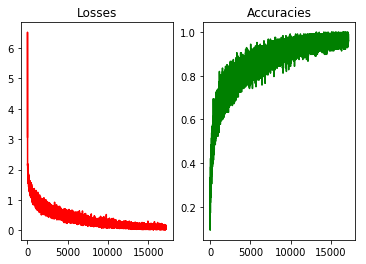

validation for epoch 44
-  epoch 44: validation accuracy = 0.827
train for epoch 45
iteration (17200): loss = 0.123, accuracy = 0.953
iteration (17250): loss = 0.055, accuracy = 0.969
iteration (17300): loss = 0.100, accuracy = 0.969
iteration (17350): loss = 0.102, accuracy = 0.953
iteration (17400): loss = 0.113, accuracy = 0.977
iteration (17450): loss = 0.159, accuracy = 0.961
iteration (17500): loss = 0.114, accuracy = 0.961
iteration (17550): loss = 0.044, accuracy = 0.984


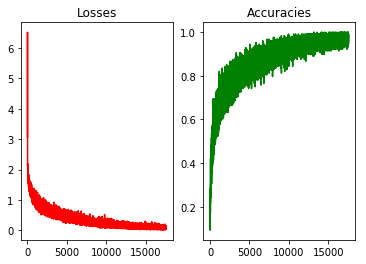

validation for epoch 45
-  epoch 45: validation accuracy = 0.823
train for epoch 46
iteration (17600): loss = 0.121, accuracy = 0.977
iteration (17650): loss = 0.094, accuracy = 0.969
iteration (17700): loss = 0.061, accuracy = 0.977
iteration (17750): loss = 0.070, accuracy = 0.977
iteration (17800): loss = 0.054, accuracy = 0.984
iteration (17850): loss = 0.058, accuracy = 0.977
iteration (17900): loss = 0.074, accuracy = 0.969
iteration (17950): loss = 0.044, accuracy = 0.977


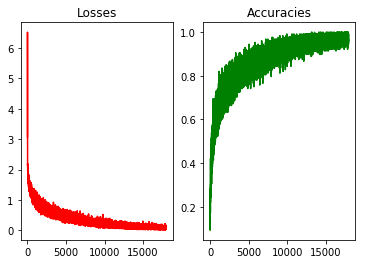

validation for epoch 46
-  epoch 46: validation accuracy = 0.818
train for epoch 47
iteration (18000): loss = 0.075, accuracy = 0.977
iteration (18050): loss = 0.060, accuracy = 0.984
iteration (18100): loss = 0.027, accuracy = 1.000
iteration (18150): loss = 0.087, accuracy = 0.969
iteration (18200): loss = 0.049, accuracy = 0.984
iteration (18250): loss = 0.081, accuracy = 0.977
iteration (18300): loss = 0.103, accuracy = 0.969


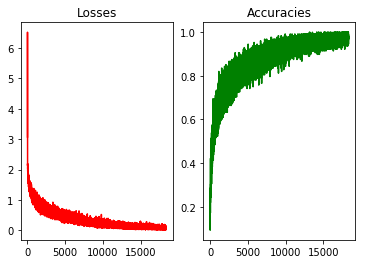

validation for epoch 47
-  epoch 47: validation accuracy = 0.839
train for epoch 48
iteration (18350): loss = 0.060, accuracy = 0.984
iteration (18400): loss = 0.082, accuracy = 0.977
iteration (18450): loss = 0.076, accuracy = 0.969
iteration (18500): loss = 0.052, accuracy = 0.977
iteration (18550): loss = 0.116, accuracy = 0.969
iteration (18600): loss = 0.125, accuracy = 0.961
iteration (18650): loss = 0.156, accuracy = 0.969
iteration (18700): loss = 0.101, accuracy = 0.992


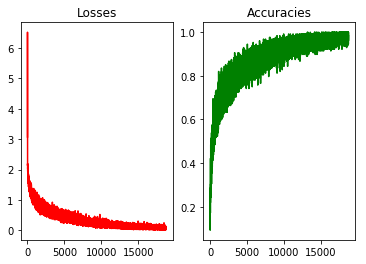

validation for epoch 48
-  epoch 48: validation accuracy = 0.839
train for epoch 49
iteration (18750): loss = 0.048, accuracy = 0.984
iteration (18800): loss = 0.087, accuracy = 0.977
iteration (18850): loss = 0.029, accuracy = 1.000
iteration (18900): loss = 0.060, accuracy = 0.992
iteration (18950): loss = 0.037, accuracy = 0.984
iteration (19000): loss = 0.162, accuracy = 0.945
iteration (19050): loss = 0.072, accuracy = 0.977


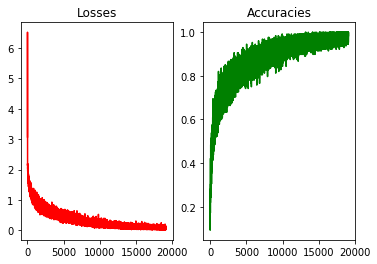

validation for epoch 49
-  epoch 49: validation accuracy = 0.810
***** test accuracy: 0.807
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [16]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
# X_train_ = X_train.reshape(-1, 32*32*3)
# scaler = StandardScaler().fit(X_train_)
# X_train_ = scaler.transform(X_train_)
# X_train_ = X_train.reshape(-1,32,32,3)
# X_val_ = scaler.transform(X_val.reshape(-1,32*32*3))
# X_val_ = X_val_.reshape(-1,32,32,3)
# X_test_ = scaler.transform(X_test.reshape(-1,32*32*3))
# X_test_ = X_test_.reshape(-1, 32,32,3)

# with open('data/processed/X_train_.pkl','rb') as f:
#     X_train_ = pickle.load(f)
# with open('data/processed/X_val_.pkl','rb') as f:
#     X_val_ = pickle.load(f)
# with open('data/processed/X_test_.pkl','rb') as f:
#     X_test_ = pickle.load(f)

print('load finished')
X_train_ = X_train
X_val_= X_val
X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [ ]:
# import pickle

In [17]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
conv1 layer: (?, 16, 16, 96)
conv2 layer: (?, 8, 8, 256)
conv3 layer: (?, 8, 8, 384)
conv4 layer: (?, 4, 4, 384)
conv5 layer: (?, 2, 2, 256)
fc6 layer: (?, 128)
fc7 layer: (?, 10)
